# Proyecto final: Telecomunicaciones (identificar operadores ineficaces)

# Índice

1. [Introducción](#in)
2. [Objetivos](#ob)
3. [Presentación](#sen) 
4. [Análisis exploratorio de datos (EDA)](#eda)
5. [Valores nulos y duplicados](#nyd)
6. [Conviertiendo tipos de datos](#ctd)
7. [Ajustes](#aj)
8. [Métricas](#me)
9. [Umbrales](#um)
10. [Porcentajes](#pr)
11. [Prueba de hipótesis](#hp)
12. [Dashboard](#ds)
13. [Conclusiones](#cl)
14. [Recomendaciones](#rc)
15. [Fuentes de infomación](#fdi)

##  Introducción  <a class="anchor" id="in"></a>

El servicio de telefonía virtual CallMeMaybe está diseñando una nueva funcionalidad destinada a mejorar la eficiencia de sus operadores. Esta función proporcionará a los supervisores información crucial sobre los operadores que presentan bajos niveles de rendimiento, con el objetivo de optimizar el servicio y mejorar la experiencia del cliente. Para identificar a los operadores menos eficaces, se consideran diversos factores como el número de llamadas entrantes perdidas, el tiempo de espera prolongado para estas llamadas, y el bajo número de llamadas salientes realizadas, en caso de que el operador deba llevar a cabo esta tarea.

Este proyecto tiene como propósito realizar un análisis exhaustivo de los datos proporcionados por el servicio, con el fin de identificar a los operadores ineficaces a través de un análisis exploratorio de los datos disponibles. Posteriormente, se pondrán a prueba diversas hipótesis estadísticas para validar los criterios de ineficacia propuestos. Los conjuntos de datos utilizados contienen información detallada sobre el uso del servicio de telefonía, incluyendo llamadas entrantes, salientes y llamadas internas entre los operadores, lo que permitirá realizar una evaluación completa de su desempeño.

##  Objetivos  <a class="anchor" id="ob"></a>

- Llevar a cabo un análisis exploratorio de datos adecuado
- Identificar a los operadores ineficaces
- Realizar pruebas de hipótesis estadísticas

##  Presentación <a class="anchor" id="sen"></a>

https://drive.google.com/file/d/1Ardk2jsgdsu0J9MIFoTFmzcTwTuQNhsB/view?usp=sharing

##  Análisis exploratorio de datos (EDA)  <a class="anchor" id="eda"></a>

Se importan la librerías necesarias para este proyecto

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import re
import numpy as np
from scipy.stats import mannwhitneyu , ttest_ind

Se cargan los datos los cuáles estarán contenidos en data frames. 

In [2]:
call=pd.read_csv(r"C:\Users\hadgu\Documents\Proyectos_python\Proyectos\TTT\Pruebas\telecom_dataset_us.csv")
tarifa=pd.read_csv(r"C:\Users\hadgu\Documents\Proyectos_python\Proyectos\TTT\Pruebas\telecom_clients_us.csv")

Se añaden funciones que se usarán a lo largo del proyecto

In [3]:
#################################### Funciones ##############################################
#Información general para los data frames
def info(df,nombre):
    print(f"información para el data frame {nombre}")
    #Primeras 5 filas del data frame
    print(df.head())
    print("\n")
    # Usando .info() en el data frame
    print(df.info(show_counts=True))
    print("\n")
    # Usando el .describe en el data frame
    print(df.describe())
    print("\n")


def merge_metrics(df_merged, metric_df, metric_name, on_column='operator_id'):
    """
    Función para realizar el merge de una métrica con el DataFrame de operadores.

    Parameters:
    - df_merged: DataFrame principal con los operadores.
    - metric_df: DataFrame de la métrica que se va a agregar (llamadas_perdidas, tiempo_espera_promedio, etc.).
    - metric_name: Nombre de la métrica que se está agregando (se usará como nombre de columna).
    - on_column: Columna sobre la que se realiza el merge (por defecto 'operator_id').

    Returns:
    - DataFrame con la métrica añadida.
    """
    # Realizar el merge
    df_merged = df_merged.merge(metric_df.reset_index(name=metric_name), how='left', on=on_column)
    return df_merged

def plot_histogram(data, column, color, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=30, alpha=0.7, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def prueba_mannwhitney(eficaces, ineficaces, columna_eficaz, columna_ineficaz, alpha=0.05):
    """
    Realiza la prueba de Mann-Whitney U entre dos grupos y muestra los resultados.
    
    Parameters:
    - eficaces: DataFrame de operadores eficaces.
    - ineficaces: DataFrame de operadores ineficaces.
    - columna_eficaz: Nombre de la columna a comparar en el DataFrame de operadores eficaces.
    - columna_ineficaz: Nombre de la columna a comparar en el DataFrame de operadores ineficaces.
    - alpha: Nivel de significancia (por defecto 0.05).
    
    Imprime los resultados de la prueba y la interpretación.
    """
    # Realizar la prueba de Mann-Whitney U
    stat, p_value = mannwhitneyu(
        eficaces[columna_eficaz], ineficaces[columna_ineficaz], alternative='two-sided'
    )

    # Imprimir resultados de la prueba
    print(f"\nPrueba de Mann-Whitney U - {columna_eficaz} vs {columna_ineficaz}:")
    print(f"p-value: {p_value:.4f}")
    
    # Interpretación
    if p_value < alpha:
        print("Rechazamos la hipótesis nula: hay una diferencia significativa.")
    else:
        print("No podemos rechazar la hipótesis nula: no hay una diferencia significativa.")


Obtención de información general de los data frames obtenidos

In [4]:
info(call,"call")
info(tarifa,"tarifa")

información para el data frame call
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 

## Valores nulos y duplicados <a class="anchor" id="nyd"></a>

Visualización de la naturaleza  y tratamiento a valores nulos

In [5]:
print("Valores nulos en el data frame call")
print(call.isnull().sum())
print(call[call.isnull().any(axis=1)])

Valores nulos en el data frame call
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
       user_id                       date direction internal  operator_id  \
0       166377  2019-08-04 00:00:00+03:00        in    False          NaN   
7       166377  2019-08-05 00:00:00+03:00        in    False          NaN   
9       166377  2019-08-06 00:00:00+03:00        in    False          NaN   
17      166377  2019-08-07 00:00:00+03:00        in    False          NaN   
27      166377  2019-08-12 00:00:00+03:00        in    False          NaN   
...        ...                        ...       ...      ...          ...   
53876   168601  2019-11-27 00:00:00+03:00        in    False          NaN   
53880   168601  2019-11-28 00:00:00+03:00        in    False          NaN   
53889 

Se tienen valores nulos en la columna internal de 117 y operator_id de 8172 en el data frame call

In [6]:
print("Valores nulos en el data frame tarifa")
print(tarifa.isnull().sum())


Valores nulos en el data frame tarifa
user_id        0
tariff_plan    0
date_start     0
dtype: int64


No se encontraron valores nules en el data frame tarifa

Tratando valores nulos: debido a que la columna internal solo tiene 117 valores nulos de 53902 datos se opta por eliminar dicho registros, por otra parte la columna operator_id tiene 8172 valores nulos de 53902 debido a que es una cifra mayor se cambiarán por el número cero haciendo alusión a que el operador es desconocido

In [7]:
call = call.dropna(subset=['internal'])
call['operator_id'] = call['operator_id'].fillna(0)

Se comprueba si el tratamiento de valores nulos fue exitoso.

In [8]:
print("Valores nulos en el data frame call") 
print(call.isnull().sum())

Valores nulos en el data frame call
user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64


Visualización y tratamiento a valores duplicados

In [9]:
print("Data frame call\n", call.duplicated().sum())
print("Data frame tarifa\n", tarifa.duplicated().sum())

Data frame call
 4893
Data frame tarifa
 0


Se encontraron 4900 duplicados en el data frame call, mientras es que el data frame tarifa no se encontraron duplicados. Se procede a eliminar los valores duplicados en el data frame.

In [10]:
call.drop_duplicates(inplace=True) 
print("Data frame call\n", call.duplicated().sum()) 

Data frame call
 0


##  Conviertiendo tipos de datos  <a class="anchor" id="ctd"></a>

Se cambiará el tipo de dato de las columnas referentes a la fecha en cada data frame con el fin de que sean tipo datetime y en el caso de la columna internal de call se asegurará que sus datos sean booleanos.

In [11]:
call['date'] = pd.to_datetime(call['date'], errors='coerce')
call['date'] = call['date'].dt.tz_localize(None)
tarifa['date_start'] = pd.to_datetime(tarifa['date_start'], errors='coerce')
call['internal'] = call['internal'].astype(bool)

print(call.info())
print(tarifa.info())


<class 'pandas.core.frame.DataFrame'>
Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          48892 non-null  float64       
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       ----

## Ajustes  <a class="anchor" id="aj"></a>

1. Se agregará  la columna call_espera que hace referencia a el tiempo que tarda un operador tomar una llamada.
2. Se eliminarán los casos donde si la llamada se perdió no puede tener un registro de duración mayor a cero (Dado a que nunca se realizó).
3. Se eliminarán casos donde el tiempo total de la llamada sea cero pero la misma no se registra como llamada perdida.
4. Se eliminarán casos donde la duración total de llamada es menor a la duración de la llamada sin tomar en cuenta tiempo de espera.
5. Se eliminará llamadas salientes sin un operador (con valor 0), debido a la perdida de esa información referente a los operadores.

In [12]:

call["call_espera"]=call['total_call_duration']-call['call_duration']
call=call[~((call["is_missed_call"] == True) & (call['call_duration'] > 0))]
call = call[~((call["is_missed_call"] == False) & (call['call_duration'] == 0))]
call = call[call['total_call_duration'] >= call['call_duration']]
call = call[~((call['direction'] == 'out') & (call['operator_id'] == 0))]

Se unen los data frames para tener toda la información en una sola tabla, se comprueba la existencia de valores nulos.

In [13]:
df_completo = pd.merge(call, tarifa, on="user_id", how="left")
print(df_completo.head())
print(df_completo.isnull().sum())

   user_id       date direction  internal  operator_id  is_missed_call  \
0   166377 2019-08-04        in     False          0.0            True   
1   166377 2019-08-05       out      True     880022.0            True   
2   166377 2019-08-05       out      True     880020.0            True   
3   166377 2019-08-05       out      True     880020.0           False   
4   166377 2019-08-05       out     False     880022.0            True   

   calls_count  call_duration  total_call_duration  call_espera tariff_plan  \
0            2              0                    4            4           B   
1            3              0                    5            5           B   
2            1              0                    1            1           B   
3            1             10                   18            8           B   
4            3              0                   25           25           B   

  date_start  
0 2019-08-01  
1 2019-08-01  
2 2019-08-01  
3 2019-08-01  
4 201

##  Métricas  <a class="anchor" id="me"></a>

Obteniendo métricas para determinar los umbrales para que un operador sea considerado ineficaz.

Para esta parte se toma en consideración:
1. Cantidad de llamadas entrantes perdidas  
2. Tiempo de espera excesivamente largo para llamadas entrantes.  
3. Un número de llamadas salientes reducido.

Se agrupa por las columnas de interés y se obtienen métricas a partir de los puntos mencionados para tomar en consideración el umbral (la suma llamadas perdidas, suma de llamadas tanto salientes como entrantres  y el promedio de tiempo de espera)

In [14]:
df_1 = df_completo.groupby(["operator_id", "tariff_plan", "direction","internal"]).agg(
is_missed_call_sum=('is_missed_call', 'sum'),   # Sumar 'is_missed_call'
    calls_count_sum=('calls_count', 'sum'),     # Sumar 'calls_count'
    call_duration_mean=('call_espera', 'mean')  # Promedio de 'call_espera'
).reset_index()

print(df_1.head())


   operator_id tariff_plan direction  internal  is_missed_call_sum  \
0          0.0           A        in     False                1100   
1          0.0           A        in      True                  81   
2          0.0           B        in     False                2611   
3          0.0           B        in      True                  86   
4          0.0           C        in     False                3159   

   calls_count_sum  call_duration_mean  
0            58609          364.160808  
1              346           84.988506  
2            24335          164.469396  
3              373           82.720930  
4            20010          125.951887  


Debido a que solo queremos los casos en los que las llamadas sean entrantes para las llamadas perdidas y el promedio de duración en espera, se filtra a partir de la columna "dirección". Posteriormente, se eliminan dicha columna y el recuento de llamadas, ya que de esta última solo nos interesan las llamadas salientes. 

In [15]:
#Solo queremos cuando direction es in para is_missed_call_sum y call_duration_mean
df_in=df_1[df_1["direction"]=="in"]
df_in=df_in.drop(columns=['calls_count_sum', 'direction'])
print(df_in.head())

   operator_id tariff_plan  internal  is_missed_call_sum  call_duration_mean
0          0.0           A     False                1100          364.160808
1          0.0           A      True                  81           84.988506
2          0.0           B     False                2611          164.469396
3          0.0           B      True                  86           82.720930
4          0.0           C     False                3159          125.951887


Para el caso del recuento de llamadas, solo nos interesa cuando la dirección es considerada como llamada saliente, por lo que se filtra por la columna direction cuando su valor es "out", y por la columna operator_id, que se utilizará como punto de unión entre los data frames obtenidos.

In [16]:
#Solo queremos cuando direction es out para calls_count_sum
df_out=df_1[df_1["direction"]=="out"][["operator_id","calls_count_sum"]]
print(df_out.sample(5))


      operator_id  calls_count_sum
767      912722.0              225
1240     930586.0              223
1778     945294.0             3368
1702     941842.0                3
697      908640.0            14234


Se utiliza la columna operator_id para poder unir los data frames y así solo tener los datos relevantes para obtener los umbrales.

In [17]:
# Uniendo los DataFrames por 'operator_id'
df_merged = pd.merge(df_in, df_out, on='operator_id', how='outer')
print(df_merged.head())

   operator_id tariff_plan internal  is_missed_call_sum  call_duration_mean  \
0          0.0           A    False              1100.0          364.160808   
1          0.0           A     True                81.0           84.988506   
2          0.0           B    False              2611.0          164.469396   
3          0.0           B     True                86.0           82.720930   
4          0.0           C    False              3159.0          125.951887   

   calls_count_sum  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  


Ahora que tenemos solo las métricas que necesitamos hay que tratar los valores nulos, estos se generan debido a las condiciones que se consideraron, en este caso los valores nulos se toman como valores desconicidos dependiendo de cada caso (descnocido o 0)

In [18]:
# Rellenando valores NaN en columnas importantes
df_merged['tariff_plan'] = df_merged['tariff_plan'].fillna('desconocido')
df_merged['internal'] = df_merged['internal'].fillna('desconocido')
df_merged['calls_count_sum'] = df_merged['calls_count_sum'].fillna(0)
df_merged['is_missed_call_sum'] = df_merged['is_missed_call_sum'].fillna(0)
df_merged['call_duration_mean'] = df_merged['call_duration_mean'].fillna(0)
df_merged['calls_count_sum'] = df_merged['calls_count_sum'].fillna(0)
print(df_merged.head())

   operator_id tariff_plan internal  is_missed_call_sum  call_duration_mean  \
0          0.0           A    False              1100.0          364.160808   
1          0.0           A     True                81.0           84.988506   
2          0.0           B    False              2611.0          164.469396   
3          0.0           B     True                86.0           82.720930   
4          0.0           C    False              3159.0          125.951887   

   calls_count_sum  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


## Umbrales  <a class="anchor" id="um"></a>
En esta parte, se considerarán diferentes formas para obtener los umbrales. Dada la naturaleza de los valores, no podemos considerar únicamente un solo caso; más bien, debemos adaptarlos a la condición humana.

1. Se calculara el promedio de los datos.
2. Se calculara la media de los datos.
3. Se calculara el percentil 90 de los datos.

In [19]:
# Calculando el promedio
promedio_calls_count_sum = df_merged['calls_count_sum'].mean()
promedio_is_missed_call_sum = df_merged['is_missed_call_sum'].mean()
promedio_call_duration_mean = df_merged['call_duration_mean'].mean()
print(f"Promedio de calls_count_sum: {promedio_calls_count_sum}")
print(f"Promedio de is_missed_call_sum: {promedio_is_missed_call_sum}")
print(f"Promedio de call_duration_mean: {promedio_call_duration_mean}")

Promedio de calls_count_sum: 374.73348519362185
Promedio de is_missed_call_sum: 4.421412300683372
Promedio de call_duration_mean: 42.521910535354785


In [20]:
# Calculando la media
media_calls_count_sum = df_merged['calls_count_sum'].median()
media_is_missed_call_sum = df_merged['is_missed_call_sum'].median()
media_call_duration_mean = df_merged['call_duration_mean'].median()
print(f"Mediana de calls_count_sum: {media_calls_count_sum}")
print(f"Mediana de is_missed_call_sum: {media_is_missed_call_sum}")
print(f"Mediana de call_duration_mean: {media_call_duration_mean}")

Mediana de calls_count_sum: 12.0
Mediana de is_missed_call_sum: 0.0
Mediana de call_duration_mean: 20.0


In [21]:
# Calcular los percentiles 90 de las columnas seleccionadas
percentil_90_calls_count_sum = df_merged['calls_count_sum'].quantile(0.90)
percentil_90_is_missed_call_sum = df_merged['is_missed_call_sum'].quantile(0.90)
percentil_90_call_duration_mean = df_merged['call_duration_mean'].quantile(0.90)

# Imprimir los resultados
print(f"Percentil 90 de calls_count_sum: {percentil_90_calls_count_sum}")
print(f"Percentil 90 de is_missed_call_sum: {percentil_90_is_missed_call_sum}")
print(f"Percentil 90 de call_duration_mean: {percentil_90_call_duration_mean}")

Percentil 90 de calls_count_sum: 972.0
Percentil 90 de is_missed_call_sum: 1.0
Percentil 90 de call_duration_mean: 92.66666666666667


Para tener una idea de como seleccionar los umbrales tenemos que ver como es que se distibuyen los datos

In [22]:
# Llamadas perdidas
print(df_merged['is_missed_call_sum'].value_counts())
# Duración promedio de espera
print(df_merged['call_duration_mean'].value_counts())
# Llamadas salientes por operador
print(df_merged['calls_count_sum'].value_counts())

is_missed_call_sum
0.0       1495
1.0        137
2.0         53
3.0         23
4.0         14
10.0         6
5.0          5
12.0         4
6.0          4
7.0          3
13.0         2
8.0          2
86.0         1
2611.0       1
81.0         1
1100.0       1
112.0        1
3159.0       1
16.0         1
11.0         1
Name: count, dtype: int64
call_duration_mean
0.000000     478
13.000000     22
20.000000     20
9.000000      20
14.000000     19
            ... 
62.000000      1
88.583333      1
48.052632      1
31.285714      1
62.700000      1
Name: count, Length: 606, dtype: int64
calls_count_sum
0.0       249
1.0       179
2.0        88
3.0        78
4.0        54
         ... 
612.0       1
354.0       1
1484.0      1
1530.0      1
79.0        1
Name: count, Length: 474, dtype: int64


Debido a que la visualización es difícil al ver solo los datos en algunos casos, se procede a graficar. Se usa la función mostrada previamente.

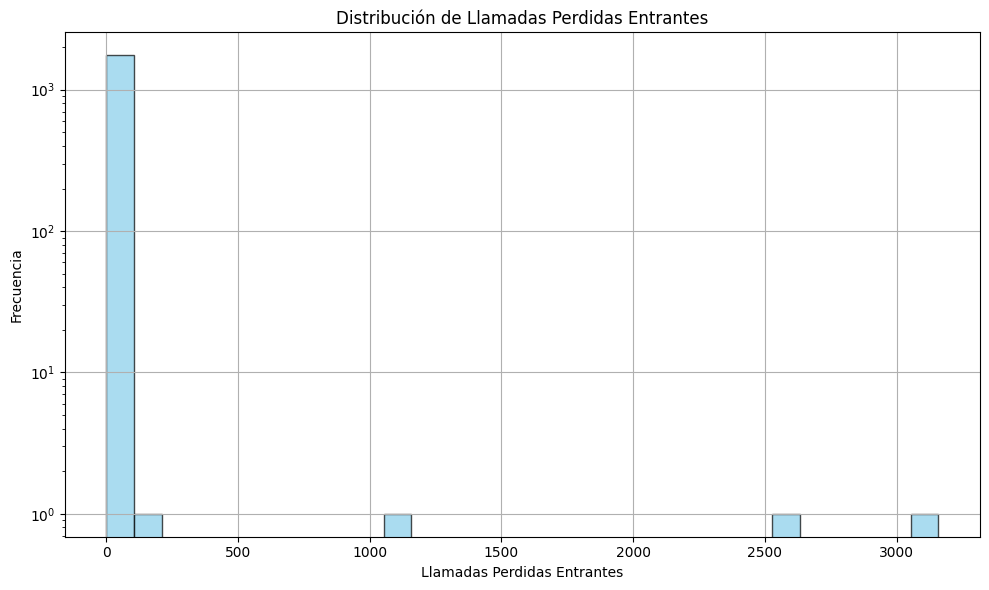

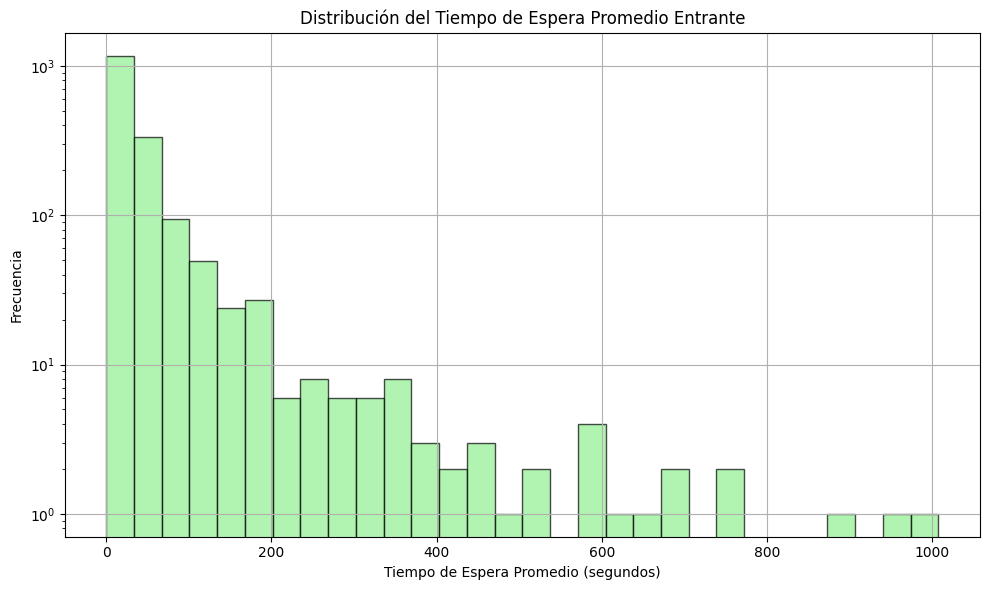

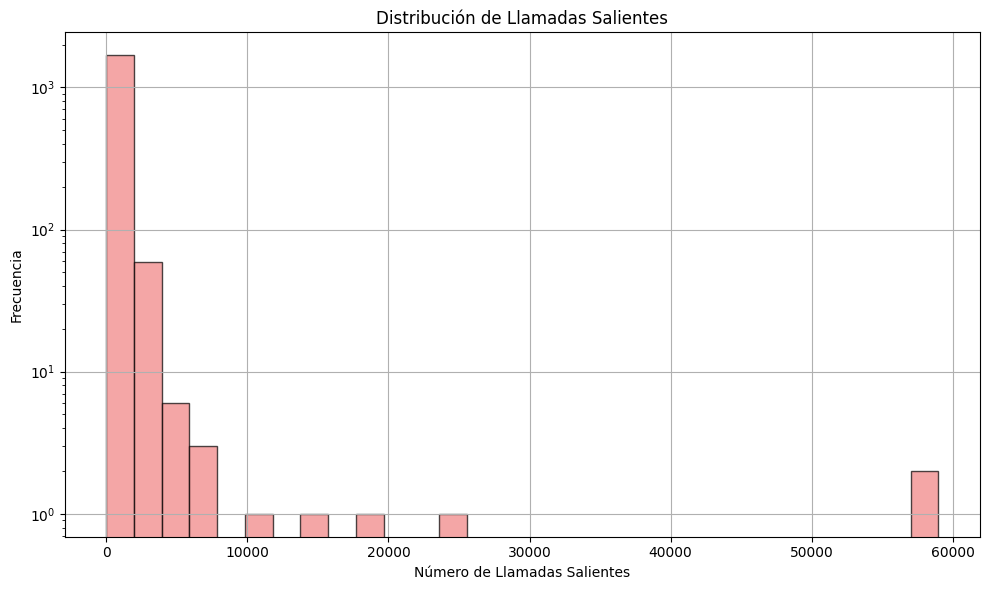

In [23]:
# Usando la función para dibujar los histogramas
plot_histogram(df_merged, 'is_missed_call_sum', 'skyblue', 'Distribución de Llamadas Perdidas Entrantes', 'Llamadas Perdidas Entrantes', 'Frecuencia')
plot_histogram(df_merged, 'call_duration_mean', 'lightgreen', 'Distribución del Tiempo de Espera Promedio Entrante', 'Tiempo de Espera Promedio (segundos)', 'Frecuencia')
plot_histogram(df_merged, 'calls_count_sum', 'lightcoral', 'Distribución de Llamadas Salientes', 'Número de Llamadas Salientes', 'Frecuencia')

Los ejes de las gráficas se ajustaron de tal manera que permiten visualizar de forma más clara cómo se comportan los datos. Tomando en cuenta los umbrales obtenidos, las gráficas y considerando la condición humana, se optó por utilizar la siguiente combinación:

El promedio de llamadas perdidas.

El promedio del tiempo de espera para responder una llamada.

La media de las llamadas salientes.

In [24]:
# operadores ineficaces
df_merged['ineficaz'] = (df_merged['is_missed_call_sum'] > promedio_is_missed_call_sum) | \
                                 (df_merged['call_duration_mean'] > promedio_call_duration_mean) | \
                                 (df_merged['calls_count_sum'] < media_calls_count_sum)

##  Porcentajes  <a class="anchor" id="pr"></a>

Ahora que hemos establecido los operadores ineficaces, procedemos a filtrar el DataFrame para obtener los porcentajes de operadores eficaces e ineficaces.

In [25]:
operadores_ineficaces = df_merged[df_merged['ineficaz'] == True]
total_operadores = len(df_merged) # Número total de operadores
num_operadores_ineficientes = df_merged[df_merged['ineficaz'] == True].shape[0] # Número de operadores ineficaces
num_operadores_eficaces = total_operadores - num_operadores_ineficientes # Número de operadores eficaces
porcentaje_ineficientes = (num_operadores_ineficientes / total_operadores) * 100 # Porcentaje de operadores ineficaces
porcentaje_eficaces = (num_operadores_eficaces / total_operadores) * 100 # Porcentaje de operadores eficaces

print(f"Porcentaje de operadores ineficaces: {porcentaje_ineficientes:.2f}%")
print(f"Porcentaje de operadores eficaces: {porcentaje_eficaces:.2f}%")


Porcentaje de operadores ineficaces: 64.07%
Porcentaje de operadores eficaces: 35.93%


Tras filtrar el DataFrame, se obtuvieron los siguientes resultados: el porcentaje de operadores ineficaces es del 64.07%, mientras que el porcentaje de operadores eficaces es del 35.93%.

##  Prueba de hipótesis  <a class="anchor" id="hp"></a>

Se realizarán tres pruebas de hipótesis, para ello primero se crean los grupos correspondientes a anlizar.

In [26]:
eficaces = df_merged[df_merged['ineficaz'] == False]
ineficaces = df_merged[df_merged['ineficaz'] == True]

1. Test de Hipótesis 1.Llamadas Perdidas Entrantes (is_missed_call_sum) 

H0 (Hipótesis Nula): No hay diferencia significativa en el número de llamadas perdidas entrantes entre operadores eficaces e ineficaces. En otras palabras, las medias de llamadas perdidas entre los dos grupos son iguales. 
𝐻0: 𝜇 eficaz = 𝜇 ineficaz

H1 (Hipótesis Alternativa): Hay una diferencia significativa en el número de llamadas perdidas entrantes entre operadores eficaces e ineficaces. Es decir, las medias son diferentes.
𝐻1: 𝜇 eficaz ≠ 𝜇 ineficaz


In [27]:
prueba_mannwhitney(eficaces, ineficaces, 'is_missed_call_sum', 'is_missed_call_sum', alpha=0.05)



Prueba de Mann-Whitney U - is_missed_call_sum vs is_missed_call_sum:
p-value: 0.0000
Rechazamos la hipótesis nula: hay una diferencia significativa.


2. Duración del Tiempo de Espera para Responder una Llamada (call_duration_mean)

H₀ (Hipótesis Nula): No hay diferencia significativa en el tiempo de espera para responder una llamada entre operadores eficaces e ineficaces. Las medias de tiempo de espera entre los dos grupos son iguales.
𝐻₀: 𝜇 eficaz = 𝜇 ineficaz

H₁ (Hipótesis Alternativa): Hay una diferencia significativa en el tiempo de espera para responder una llamada entre operadores eficaces e ineficaces. Las medias son diferentes.
𝐻₁: 𝜇 eficaz ≠ 𝜇 ineficaz

In [28]:
prueba_mannwhitney(eficaces, ineficaces, 'call_duration_mean', 'call_duration_mean', alpha=0.05)



Prueba de Mann-Whitney U - call_duration_mean vs call_duration_mean:
p-value: 0.0000
Rechazamos la hipótesis nula: hay una diferencia significativa.


3. Llamadas Salientes (calls_count_sum)

H₀ (Hipótesis Nula): No hay diferencia significativa en el número de llamadas salientes realizadas entre operadores eficaces e ineficaces. Las medias de llamadas salientes entre los dos grupos son iguales.
𝐻₀: 𝜇 eficaz = 𝜇 ineficaz

H₁ (Hipótesis Alternativa): Hay una diferencia significativa en el número de llamadas salientes realizadas entre operadores eficaces e ineficaces. Las medias son diferentes.
𝐻₁: 𝜇 eficaz ≠ 𝜇 ineficaz

In [29]:
prueba_mannwhitney(eficaces, ineficaces, 'calls_count_sum', 'calls_count_sum', alpha=0.05)


Prueba de Mann-Whitney U - calls_count_sum vs calls_count_sum:
p-value: 0.0000
Rechazamos la hipótesis nula: hay una diferencia significativa.


En todos los casos, se rechaza la hipótesis nula, ya que los valores p son menores que el nivel de significancia (0.05). Esto indica que hay diferencias significativas entre los operadores eficaces e ineficaces en relación con las tres métricas analizadas: llamadas perdidas, tiempo de espera promedio y número de llamadas salientes.

Las diferencias observadas entre los dos grupos son estadísticamente significativas, lo que sugiere que los operadores eficaces y los ineficaces muestran comportamientos distintos en estos aspectos. Por lo tanto, podemos concluir que el comportamiento entre un operador eficaz y uno ineficaz es lo suficientemente grande como para ser relevante y destacar.

##  Dashboard <a class="anchor" id="ds"></a>

https://public.tableau.com/app/profile/h.ctor.mart.nez7696/viz/Dashboard_17405940593230/Dashboard1?publish=yes

##  Conclusiones  <a class="anchor" id="cl"></a>

Hablando de la Eficacia de los Operadores:
Los operadores clasificados como eficaces muestran un comportamiento más eficiente, caracterizado por una menor cantidad de llamadas perdidas, tiempos de duración de llamada más cortos y un mayor número de llamadas realizadas. Por el contrario, los operadores ineficaces presentan mayores cantidades de llamadas perdidas, tiempos de espera más largos y menos llamadas realizadas, de una manera claramente notable.

Estas observaciones están respaldadas por la significancia estadística. Las pruebas de Mann-Whitney U revelan diferencias claras y significativas en todos los aspectos evaluados, lo que refuerza la distinción entre operadores eficaces e ineficaces. Esto sugiere que la diferencia entre ambos grupos es lo suficientemente grande y determinante como para justificar esta clasificación.



## Recomendaciones <a class="anchor" id="rc"></a>

Es importante considerar las diferencias encontradas entre los operadores eficaces e ineficaces para diseñar intervenciones que mejoren el desempeño de estos últimos. Algunas recomendaciones incluyen:

# Capacitación y Entrenamiento
1. Mejora en la gestión del tiempo de llamada:
Si los operadores ineficaces tienen tiempos de duración de llamadas más largos, sería beneficioso ofrecer capacitación específica sobre cómo gestionar mejor las llamadas para ser más eficientes, sin sacrificar la calidad del servicio. Esto podría incluir habilidades de comunicación, técnicas para manejar objeciones rápidamente o estrategias de cierre de llamadas más efectivas.

2. Manejo de llamadas perdidas:
Para los operadores con más llamadas perdidas, desarrollar un programa de capacitación enfocado en cómo mejorar la respuesta en el momento adecuado sería útil. Esto podría implicar enseñarles a ser más rápidos al contestar llamadas y evitar pérdidas innecesarias.

# Optimización del Proceso de Llamadas
3. Mejorar la distribución de las llamadas:
Si los operadores ineficaces están sobrecargados o no reciben el tipo de llamadas que mejor manejan, podría ser beneficioso revisar la distribución de las llamadas. Así, los operadores eficaces podrían manejar un mayor volumen, mientras que los ineficaces recibirían llamadas más ajustadas a sus habilidades, lo que optimizaría el rendimiento general.

# Incentivos y Motivación
4. Programas de incentivos:
Establecer un sistema de incentivos puede motivar a los operadores a mejorar su rendimiento. Por ejemplo, recompensar a los operadores que logren reducir su tiempo de llamada o disminuir las llamadas perdidas podría ser un aliciente para que trabajen en mejorar sus métricas.

# Ajuste en la Clasificación de Operadores

5. Ajustar los umbrales de clasificación:
Si las definiciones de "eficaz" e "ineficaz" están basadas únicamente en las métricas, estas podrían resultar demasiado rígidas. Podría ser útil ajustar los umbrales para clasificar a los operadores, considerando factores externos que también pueden influir en su desempeño, lo cual evitaría clasificaciones erróneas que no reflejan completamente las capacidades de los operadores.



## Fuentes de infomación <a class="anchor" id="fdi"></a>

1. Establecer links entre el índice y el contenido del documento.

Stack Overflow. (2013, agosto 18). How can I add a table of contents to a Jupyter/JupyterLab notebook? Stack Overflow. https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook

2. Establecer la escala del eje "y" en log10 e interpretación de datos. 

Tableau. (2021, febrero 1). Log transform Tableau [Video]. YouTube. https://www.youtube.com/watch?v=KcuNi1EJYvI

3.  Prueba de hipótesis e histogramas de frecuencia.

Tripleten (2024) Sprint 5: Análisis estadístico de datos 

4. Prueba de Mann-Whitney en Python (prueba estadística no paramétrica utilizada para comparar dos grupos independientes cuando los datos no siguen una distribución normal).

SciPy.org. (n.d.). scipy.stats.mannwhitneyu. SciPy. Recuperado el 19 de febrero de 2025, de https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

5. Convertir tipo de datos de interes a tipo datetime.

Python. (n.d.). datetime — Basic date and time types. Python 3. Recuperado el 19 de febrero de 2025, de https://docs.python.org/3/library/datetime.htm


6. Combinar data frames con merge(), crear gráficas en Python con matplotlib, Histogramas

Tripleten (2024) Sprint 6: Manipulación de datos (Data Wrangling) 
